# VRTs and Cloud storage with GDAL and Rasterio

Advanced usage describes using WarpedVRT for operations, but in the end Geotiff arrays are loaded into memory or written to local disk:
https://gist.github.com/sgillies/7e5cd548110a5b4d45ac1a1d93cb17a3

What if we just want to save VRTs? There are different documented approaches, for specific casesm some of which no longer seem to work:
https://github.com/mapbox/rasterio/pull/1041#issuecomment-308625948 
https://github.com/mapbox/rasterio/pull/1029 
http://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html

VRT format is a really common output format for GDAL command line tools, so it would be great to easily write VRTs from rasterio. In particular, the format is very convenient for referencing public imagery on the Cloud such as Landsat8:

    - could be useful to keep a lightweight record of files for a particular analysis in any coordinate system.
    - easily run command line tools to retrieve subsets or overviews of data locally (if you want it)
    - use tools like gdallocationinfo for simple analysis without downloading data
    - an example notebook: 

https://github.com/scottyhq/landsat-aws-demo/blob/master/2_Landsat-8-AWS-xarray.ipynb

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import rasterio 
print(rasterio.__version__) # Must be >1
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling

1.0a12


In [3]:
import gdal
gdal.VersionInfo()
!gdalinfo --version

GDAL 2.2.2, released 2017/09/15


In [4]:
# GDAL command line tool can now access public datasets on the cloud
# here is an example with Landsat8

id='LC08_L1TP_047027_20180419_20180420_01_RT'
band=1
url=f'/vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/{id}/{id}_B{band}.TIF'
print(url)

/vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF


In [5]:
%%time
!gdalinfo {url}

Driver: GTiff/GeoTIFF
Files: /vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF
       /vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF.ovr
       /vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_MTL.txt
       /vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_MTL.txt
Size is 7861, 7971
Coordinate System is:
PROJCS["WGS 84 / UTM zone 10N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AU

In [6]:
%%time
# Try the same with rasterio command line
!rio info {url}

{"blockxsize": 512, "blockysize": 512, "bounds": [352185.0, 5135085.0, 588015.0, 5374215.0], "colorinterp": ["grey"], "compress": "deflate", "count": 1, "crs": "EPSG:32610", "descriptions": [null], "driver": "GTiff", "dtype": "uint16", "height": 7971, "indexes": [1], "interleave": "band", "lnglat": [-123.39659086399698, 47.444608553735556], "mask_flags": [["all_valid"]], "nodata": null, "res": [30.0, 30.0], "shape": [7971, 7861], "tiled": true, "transform": [30.0, 0.0, 352185.0, 0.0, -30.0, 5374215.0, 0.0, 0.0, 1.0], "units": [null], "width": 7861}
CPU times: user 24.8 ms, sys: 57 ms, total: 81.8 ms
Wall time: 1.55 s


In [7]:
# Store a local VRT file that points to the COG
gdalvrt = f'{id}_B{band}_gdal.vrt'
cmd = f'gdal_translate -of VRT {url} {gdalvrt}'
print(cmd)
!{cmd}

gdal_translate -of VRT /vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF LC08_L1TP_047027_20180419_20180420_01_RT_B1_gdal.vrt
Input file size is 7861, 7971


In [8]:
# NOTE: key is /vsicurl/ pointer in <SimpleSource> tag
!cat {gdalvrt}

<VRTDataset rasterXSize="7861" rasterYSize="7971">
  <SRS>PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]</SRS>
  <GeoTransform>  3.5218500000000000e+05,  3.0000000000000000e+01,  0.0000000000000000e+00,  5.3742150000000000e+06,  0.0000000000000000e+00, -3.0000000000000000e+01</GeoTransform>
  <Metadata>
    <MDI key="AREA_OR_POINT">Point</MDI>
  </Metadata>
  <Metadata domain="IMD">
    <MDI key="L1_METADATA_FILE.IMAGE_ATTRIBUTES.CLOUD_COVER">

In [9]:
%%time
# Use the VRT to access the COG. faster due to caching?
!gdalinfo {gdalvrt}

Driver: VRT/Virtual Raster
Files: LC08_L1TP_047027_20180419_20180420_01_RT_B1_gdal.vrt
       /vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF
Size is 7861, 7971
Coordinate System is:
PROJCS["WGS 84 / UTM zone 10N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-123],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Nort

In [10]:
# Do something other than get metadata
cmd = f'gdallocationinfo -wgs84 {gdalvrt} -122.335167 47.608013'
print(cmd)
!{cmd}

gdallocationinfo -wgs84 LC08_L1TP_047027_20180419_20180420_01_RT_B1_gdal.vrt -122.335167 47.608013
Report:
  Location: (6592P,3375L)
  Band 1:
    <LocationInfo><File>/vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF</File></LocationInfo>
    Value: 10439


In [11]:
%%time
# Seems that rasterio can READ, but NOT WRITE these VRTs:
!rio info {gdalvrt}

{"blockxsize": 128, "blockysize": 128, "bounds": [352185.0, 5135085.0, 588015.0, 5374215.0], "colorinterp": ["grey"], "count": 1, "crs": "EPSG:32610", "descriptions": [null], "driver": "VRT", "dtype": "uint16", "height": 7971, "indexes": [1], "lnglat": [-123.39659086399698, 47.444608553735556], "mask_flags": [["all_valid"]], "nodata": null, "res": [30.0, 30.0], "shape": [7971, 7861], "tiled": true, "transform": [30.0, 0.0, 352185.0, 0.0, -30.0, 5374215.0, 0.0, 0.0, 1.0], "units": [null], "width": 7861}
CPU times: user 18.4 ms, sys: 44.6 ms, total: 63 ms
Wall time: 1.22 s


In [12]:
%%time
# Try to save a local vrt with rasterio/rio
# NOTE: creates incomplete VRT... and eventually produces an error
riovrt = f'{id}_B{band}_rio.vrt'
cmd = f'rio convert -f VRT {url} {riovrt}'
print(cmd)
!{cmd}

rio convert -f VRT /vsicurl/landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF LC08_L1TP_047027_20180419_20180420_01_RT_B1_rio.vrt
Traceback (most recent call last):
  File "/Users/scott/miniconda3/envs/rasterio1/bin/rio", line 11, in <module>
    sys.exit(main_group())
  File "/Users/scott/miniconda3/envs/rasterio1/lib/python3.6/site-packages/click/core.py", line 722, in __call__
    return self.main(*args, **kwargs)
  File "/Users/scott/miniconda3/envs/rasterio1/lib/python3.6/site-packages/click/core.py", line 697, in main
    rv = self.invoke(ctx)
  File "/Users/scott/miniconda3/envs/rasterio1/lib/python3.6/site-packages/click/core.py", line 1066, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/scott/miniconda3/envs/rasterio1/lib/python3.6/site-packages/click/core.py", line 895, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/Users/scott/minicon

In [13]:
%%time
with rasterio.open(gdalvrt) as src:
    profile = src.profile.copy()
    profile.update(driver='VRT')
    with rasterio.open('out.vrt', 'w', **profile) as dst:
        dst.write(src.read())

OSError: Read or write failed

CPU times: user 38.5 ms, sys: 6.36 ms, total: 44.9 ms
Wall time: 1.61 s


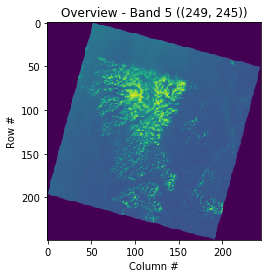

In [14]:
%%time
oview = 32
with rasterio.open(gdalvrt) as src:
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
plt.imshow(thumbnail)
plt.title('Overview - Band 5 ({})'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [15]:
# Seems that rasterio *should* be able to write VRTs:

# "from rasterio import copy" approach described here doesn't seem to work 
#https://github.com/mapbox/rasterio/pull/1041#issuecomment-308625948

from rasterio import copy

ImportError: cannot import name 'copy'

In [16]:
%%time
# This issue demonstrates operating on a WarpedVRT 
# but then saving locally as Geotif:
#https://github.com/mapbox/rasterio/pull/1029

# down in comments describes a non-intuitive way to save VRTs:
# NOTE: this does not generate an error, but does not save the pointer
# to the file on Cloud storage and therefore does not work.
from rasterio.warp import reproject

with rasterio.open(url) as src:
    print(src.tags())
    print(src.profile)
    profile = src.profile.copy()
    profile.update(driver='VRT')
    with rasterio.open('out.vrt', 'w', **profile) as dst:
        for bidx in range(1, src.count + 1):
            reproject(
                rasterio.band(src, bidx),
                rasterio.band(dst, bidx))

{'AREA_OR_POINT': 'Point'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7861, 'height': 7971, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 352185.0,
       0.0, -30.0, 5374215.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
CPU times: user 713 ms, sys: 606 ms, total: 1.32 s
Wall time: 27.2 s


In [17]:
%%time
# Yet another approach to saving a VRT, which does seem to work!
#http://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html

from rasterio import shutil as rio_shutil
from rasterio.vrt import WarpedVRT

# NOTE: just try to save a VRT without doing any coordinate transformation

# Dump the aligned data into a new file.  A VRT representing
# this transformation can also be produced by switching
# to the VRT driver.
with rasterio.open(url) as src:
    print(src.tags())
    print(src.profile)
    
    with WarpedVRT(src) as vrt:    
        outfile = riovrt
        rio_shutil.copy(vrt, outfile, driver='VRT')

{'AREA_OR_POINT': 'Point'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7861, 'height': 7971, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 352185.0,
       0.0, -30.0, 5374215.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
CPU times: user 9.77 ms, sys: 6.85 ms, total: 16.6 ms
Wall time: 167 ms


In [18]:
# NOTE: VRT from rasterio is not quite the same as the one produced by gdal_translate:
print('VRT saved by gdal_translate:')
print('------------------')
with rasterio.open(gdalvrt) as src:
    print(src.tags())
    print(src.profile)
    
print('VRT saved by rasterio:')
print('------------------')
with rasterio.open(riovrt) as src:
    print(src.tags())
    print(src.profile)

VRT saved by gdal_translate:
------------------
{'AREA_OR_POINT': 'Point'}
{'driver': 'VRT', 'dtype': 'uint16', 'nodata': None, 'width': 7861, 'height': 7971, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 352185.0,
       0.0, -30.0, 5374215.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}
VRT saved by rasterio:
------------------
{}
{'driver': 'VRT', 'dtype': 'uint16', 'nodata': None, 'width': 7861, 'height': 7971, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.000000000000004, 0.0, 352185.0,
       0.0, -30.000000000000004, 5374215.0), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
